# Transfer Learning 

__`Group Number:`__ 

# **10**

__`Group Members`__ 

|STUDENT NAME|STUDENT NUMBER|EMAIL|
|---|---|---|
|Ianis Rușitoru|20220620|20220620@novaims.unl.pt|
|Ricardo Almeida|20220584|20220584@novaims.unl.pt|
|Nichita Zamisnii|20220617|20220617@novaims.unl.pt|
|Pedro Paris|20191217|20191217@novaims.unl.pt|


__`Links`__   

[Github Data Source](https://github.com/garythung/trashnet)

[Google Drive Project Folder](https://drive.google.com/drive/folders/1KfXat-zOA1sJ-0m4-4yhEesj48KawVAj)

__`Summary`__ 

-Step 1: Import neccesary packages, data & define functions <br>
-Step 2: Load ResNet50 Model <br>
-Step 3: Define arhitecture and train <br>
-Step 4: Train cnn7 for comparison <br>
-Step 5: Assement<br>

__`Findings`__
- ResNet50 outperforms our handcrafted model, as expected. The difference in accuracy is about 7% and loss is better.
- Transfer learning is a good way to train a model fast since handcrafting can be time-consuming and computationally expensive. Using such a tool is a good starting point which can be built uppon to achieve desired perfomance.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import datasets
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50



import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap


import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/W5/"
main_folder, training_folder, testing_folder = "reduced_dataset/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'reduced_dataset.zip', 'reduced_dataset.zip')
    # Extract files
    zip_ = zipfile.ZipFile('reduced_dataset.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 1.648 seconds


In [ ]:
image_size=(224, 224)
color_mode='rgb'
batch_size=32
label_mode="categorical"
validation_split=0.15
shuffle=True
seed=0
crop_to_aspect_ratio=True
input_shape = (*image_size, 3)

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 2028 files belonging to 5 classes.
Using 1724 files for training.
Using 304 files for validation.
Found 362 files belonging to 5 classes.


In [ ]:
def learning_curves(baseline_history, candidate_history):
    df_baseline = pd.DataFrame.from_dict(baseline_history.history)
    df_baseline["Epoch"] = np.arange(1, len(df_baseline) + 1, 1)
    df_candidate = pd.DataFrame.from_dict(candidate_history.history)
    df_candidate["Epoch"] = np.arange(1, len(df_candidate) + 1, 1)

    # Find the maximum accuracy value from both dataframes
    max_accuracy = max(df_baseline['accuracy'].max()+0.1, df_baseline['val_accuracy'].max()+0.1, 
                       df_candidate['accuracy'].max()+0.1, df_candidate['val_accuracy'].max()+0.1)

    # Plot baseline model
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    secondary_y = ["accuracy", "val_accuracy"]
    ax = df_baseline.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[0], grid=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Current Baseline Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10, legend=None)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.set_ylim([0, max_accuracy])  # Set the limit for the right y-axis

    # Plot candidate model
    ax = df_candidate.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[1], grid=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Candidate Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10, legend=None)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.set_ylim([0, max_accuracy])  # Set the limit for the right y-axis

    fig.subplots_adjust(wspace=0.3) # Increase horizontal space between subplots

    # Add a single legend outside the plot area
    lines = [axs[0].lines[0], axs[0].lines[1], axs[0].right_ax.lines[0], axs[0].right_ax.lines[1]]
    labels = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

    plt.show()


def compare_models(model1, model2, test_data):
  results1 = model1.evaluate(test_data)
  results2 = model2.evaluate(test_data)
    
  print("Current Baseline Model")
  print(f"Test loss: {results1[0]:.4f}")
  print(f"Test accuracy: {results1[1]:.4f}")
    
  print("\nCandidate Model")
  print(f"Test loss: {results2[0]:.4f}")
  print(f"Test accuracy: {results2[1]:.4f}")


def get_checkpoint_callback(model_name):
    # Define the checkpoint filepath
    checkpoint_filepath = f'best_weights_{model_name}.h5'

    # Create the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    return checkpoint_callback, checkpoint_filepath

__`Step 2`__ Load the pre-trained ResNet50 model without the top classification layer and freeze the weights of the convolutional layers. The weights used are from imagenet

In [ ]:
# Load
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze
for layer in resnet_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


__`Step 3`__ Define arhitecture:
- Base output of ResNet50
- GlobalAveragePooling2D 
- Two dense layers with 256 and 128 neurons, both using kernel regulaziers to prevent overfitting
- Two dropout layers, each after every dense layer to further prevent overfitting
- Output layer

In [ ]:
x = resnet_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5)(x)

transferModel = tf.keras.models.Model(inputs=resnet_base.input, outputs=predictions)



# Compile the model
transferModel.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

transferModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Train the defined model

In [ ]:
callback, filepath = get_checkpoint_callback('model')
history = transferModel.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback])
transferModel.load_weights(filepath)

Epoch 1/100
54/54 [==============================] - 16s 192ms/step - loss: 8.1132 - accuracy: 0.2906 - val_loss: 7.2028 - val_accuracy: 0.5888
Epoch 2/100
54/54 [==============================] - 9s 146ms/step - loss: 7.2584 - accuracy: 0.4635 - val_loss: 6.7748 - val_accuracy: 0.6579
Epoch 3/100
54/54 [==============================] - 7s 132ms/step - loss: 6.8210 - accuracy: 0.5638 - val_loss: 6.4245 - val_accuracy: 0.7138
Epoch 4/100
54/54 [==============================] - 7s 133ms/step - loss: 6.4853 - accuracy: 0.5986 - val_loss: 6.1132 - val_accuracy: 0.7632
Epoch 5/100
54/54 [==============================] - 7s 131ms/step - loss: 6.1688 - accuracy: 0.6421 - val_loss: 5.8384 - val_accuracy: 0.7697
Epoch 6/100
54/54 [==============================] - 8s 140ms/step - loss: 5.8572 - accuracy: 0.7059 - val_loss: 5.5739 - val_accuracy: 0.8092
Epoch 7/100
54/54 [==============================] - 8s 143ms/step - loss: 5.5931 - accuracy: 0.7314 - val_loss: 5.3513 - val_accuracy: 0.809

__`Step 4`__  Train the champion model in order to compare performance

In [ ]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.15), 
                           layers.RandomZoom(height_factor=0.15, width_factor=0.1),
                           layers.RandomBrightness(factor=0.15),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

cnn7 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, (11, 11), activation='relu'), # New kernel size
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'), # New kernel size
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5)
])

cnn7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn7.summary()

callback7, filepath7 = get_checkpoint_callback('model7')
history7 = cnn7.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback7])
cnn7.load_weights(filepath7)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (None, 224, 224, 3)      0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 214, 214, 32)      11648     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      51264     
                                                        

Plot learning curves and compare performance

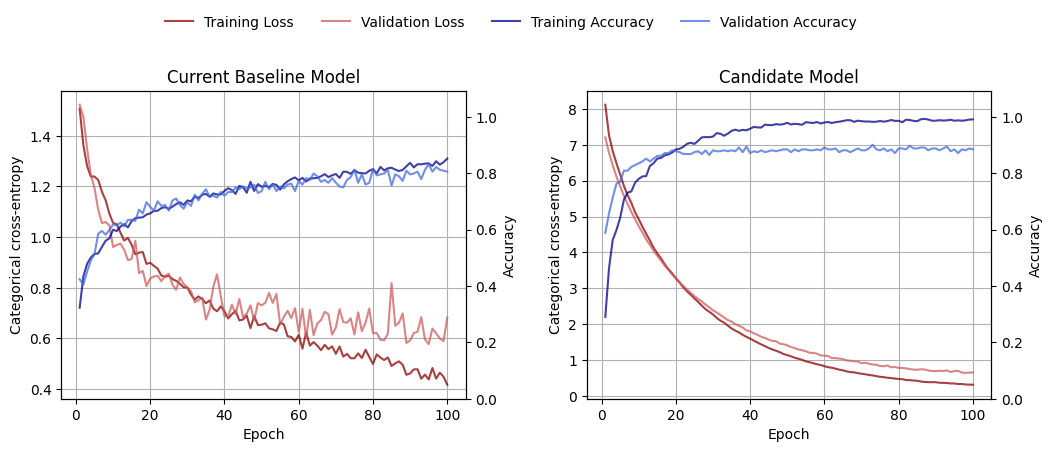

In [ ]:
learning_curves(history7, history)

In [ ]:
compare_models(cnn7, transferModel, ds_test)

12/12 [==============================] - 2s 151ms/step - loss: 0.6149 - accuracy: 0.8702
Current Baseline Model
Test loss: 0.6414
Test accuracy: 0.7845

Contender Model
Test loss: 0.6149
Test accuracy: 0.8702


__`Assesment`__ The transfer learning model is perfoming decisively better than the handcrafted model. It has a test accuracy of 87% and a loss of 0.61. In comparison, cnn7 performs worse on both metrics.

__`Conclusion`__ The transfer learning model outperforms cnn7. On the other hand it overfits so a better way to regularize might possible.